In [1]:
import os
%load_ext autoreload
%autoreload 2
from model import preds
import cv2
import json
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import time

Ensure that the backend server is running using:
```python project\backend\model_inference\model_inference_app.py```

In [2]:
validation_dataset = "../../../images/validation"

In [3]:
#Running single prediction
image_path = validation_dataset + '/Recyclable/R_987.jpg'
img = cv2.imread(image_path)
pil_image = Image.fromarray(img)
results = preds([pil_image], 'efficientnet_v2_l')
print(json.dumps(results, indent=2))

[
  {
    "object_class": "water bottle",
    "object_class_probs": [
      0.1361638605594635,
      0.1333187371492386,
      0.12534385919570923,
      0.10615894198417664,
      0.09687449038028717,
      0.09521940350532532,
      0.09200046211481094,
      0.07593291252851486,
      0.06968806684017181,
      0.06929928809404373
    ],
    "object_classes": [
      "water bottle",
      "perfume",
      "pop bottle",
      "water jug",
      "whiskey jug",
      "cocktail shaker",
      "vase",
      "nipple",
      "eggnog",
      "beer bottle"
    ],
    "object_trash_class": "Recyclable",
    "object_trash_class_probs": [
      0.4871011504899743,
      0.5128988495100257,
      0.0,
      0.0
    ],
    "trash_class": "Recyclable",
    "trash_class_probs": [
      0.4871011504899743,
      0.5128988495100257,
      0.0,
      0.0
    ],
    "trash_classes": [
      "Garbage",
      "Recyclable",
      "Organic Waste",
      "Household hazardous waste"
    ]
  }
]


In [4]:
labels_dict = {}
predicted_classes_dict = {}
time_dict = {}

"""
Avaliable models to validate
1. GPU model: ViT-g-14 (5.47 GB)
2. GPU model: ViT-H-14 (3.94 GB)
3. CPU model: ViT-L-14 (1.71 GB)
4. CPU model: ViT-B-16 (599 MB)
"""

#List of all models to validate, 
models_to_validate = ['efficientnet_v2_l', 'ViT-g-14', 'ViT-L-14', 'ViT-B-16']

#Run the validation on each of the model.
for model in models_to_validate:
    print(f"Validating {model}...")

    #For each new model it will reinitialize the variable 
    predicted_classes = []
    labels = []
    start_time = time.time()
    # loop through the directory and its subdirectories
    for root, dirs, files in os.walk(validation_dataset):
        for file in files:
            # check if the file extension is an image format
            if file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
                # return the full path to the image file
                image_path = os.path.join(root, file)
                img = cv2.imread(image_path)
                pil_image = Image.fromarray(img)
                true_label = os.path.basename(root)
                
                results = preds([pil_image], model)[0]
                predicted_label = results['trash_class']  # prefer trash_class over object_trash_class
                object_class = results['object_class']
                # print(predicted_label, object_class, true_label)
                # add the true label and predicted label to the lists
                labels.append(true_label)
                predicted_classes.append(predicted_label)
                if true_label != predicted_label:
                    print(image_path)
                    print(f'object_class: {object_class}')
                    print(f"Prediction: {predicted_label}; True label: {true_label}")
                    print()
    elapsed_time = time.time() - start_time
    print(f"Elapsed time for {model}: {elapsed_time:.2f} seconds")

    #For each model's prediction store them in the dictionary
    time_dict[model] = elapsed_time
    predicted_classes_dict[model] = predicted_classes
    labels_dict[model] = labels

Validating efficientnet_v2_l...
../../../images/validation\Garbage\trash78.jpg
object_class: packet
Prediction: Organic Waste; True label: Garbage

../../../images/validation\Household hazardous waste\alkaline-batteries2.jpg
object_class: radio
Prediction: Garbage; True label: Household hazardous waste

../../../images/validation\Organic Waste\O_12334.jpg
object_class: coral reef
Prediction: Garbage; True label: Organic Waste

../../../images/validation\Organic Waste\O_13593.jpg
object_class: banana
Prediction: Garbage; True label: Organic Waste

../../../images/validation\Organic Waste\O_13718.jpg
object_class: candle
Prediction: Garbage; True label: Organic Waste

../../../images/validation\Organic Waste\O_13720.jpg
object_class: maraca
Prediction: Garbage; True label: Organic Waste

../../../images/validation\Organic Waste\O_13750.jpg
object_class: orange
Prediction: Garbage; True label: Organic Waste

../../../images/validation\Organic Waste\O_13807.jpg
object_class: confectionery


In [5]:
for model, elapsed_time in time_dict.items():
    print(f"Elapsed time for {model}: {elapsed_time:.2f} seconds")

Elapsed time for efficientnet_v2_l: 7.72 seconds
Elapsed time for ViT-g-14: 23.55 seconds
Elapsed time for ViT-L-14: 8.68 seconds
Elapsed time for ViT-B-16: 4.54 seconds


In [6]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score

from sklearn.preprocessing import LabelEncoder

mAP_dict = {}

for model, predicted_classes in predicted_classes_dict.items():
    # create a LabelEncoder object
    le = LabelEncoder()
    # fit the encoder to your labels and transform them
    labels_encoded = le.fit_transform(labels_dict[model])
    # fit the encoder to your predicted classes and transform them
    predicted_classes_encoded = le.transform(predicted_classes)

    # convert the labels and predicted_classes lists to arrays
    labels_encoded = np.array(labels_encoded)
    predicted_classes_encoded = np.array(predicted_classes_encoded)

    # binarize the labels and predicted_classes arrays
    n_classes = len(set(labels_encoded))
    labels_bin = label_binarize(labels_encoded, classes=range(n_classes))
    predicted_classes_bin = label_binarize(predicted_classes_encoded, classes=range(n_classes))

    print(f"Model: {model}")
    print(f"labels_bin shape: {labels_bin.shape}")
    print(f"predicted_classes_bin shape: {predicted_classes_bin.shape}")

    # compute the average precision score for each class
    average_precisions = []
    for i in range(n_classes):
        average_precisions.append(average_precision_score(labels_bin[:, i], predicted_classes_bin[:, i]))

    # compute the mean average precision score
    mAP = np.mean(average_precisions)
    print(f"Mean Average Precision: {mAP:.2f}")
    print("------------------------------------------------")

    #Create dictionary to support multiple model validation
    mAP_dict[model] = mAP
    
for key, value in mAP_dict.items():
    print(key, value)

Model: efficientnet_v2_l
labels_bin shape: (97, 4)
predicted_classes_bin shape: (97, 4)
Mean Average Precision: 0.78
------------------------------------------------
Model: ViT-g-14
labels_bin shape: (97, 4)
predicted_classes_bin shape: (97, 4)
Mean Average Precision: 0.72
------------------------------------------------
Model: ViT-L-14
labels_bin shape: (97, 4)
predicted_classes_bin shape: (97, 4)
Mean Average Precision: 0.67
------------------------------------------------
Model: ViT-B-16
labels_bin shape: (97, 4)
predicted_classes_bin shape: (97, 4)
Mean Average Precision: 0.50
------------------------------------------------
efficientnet_v2_l 0.7825558977105369
ViT-g-14 0.7217932677288348
ViT-L-14 0.6734351010998718
ViT-B-16 0.501293227418851


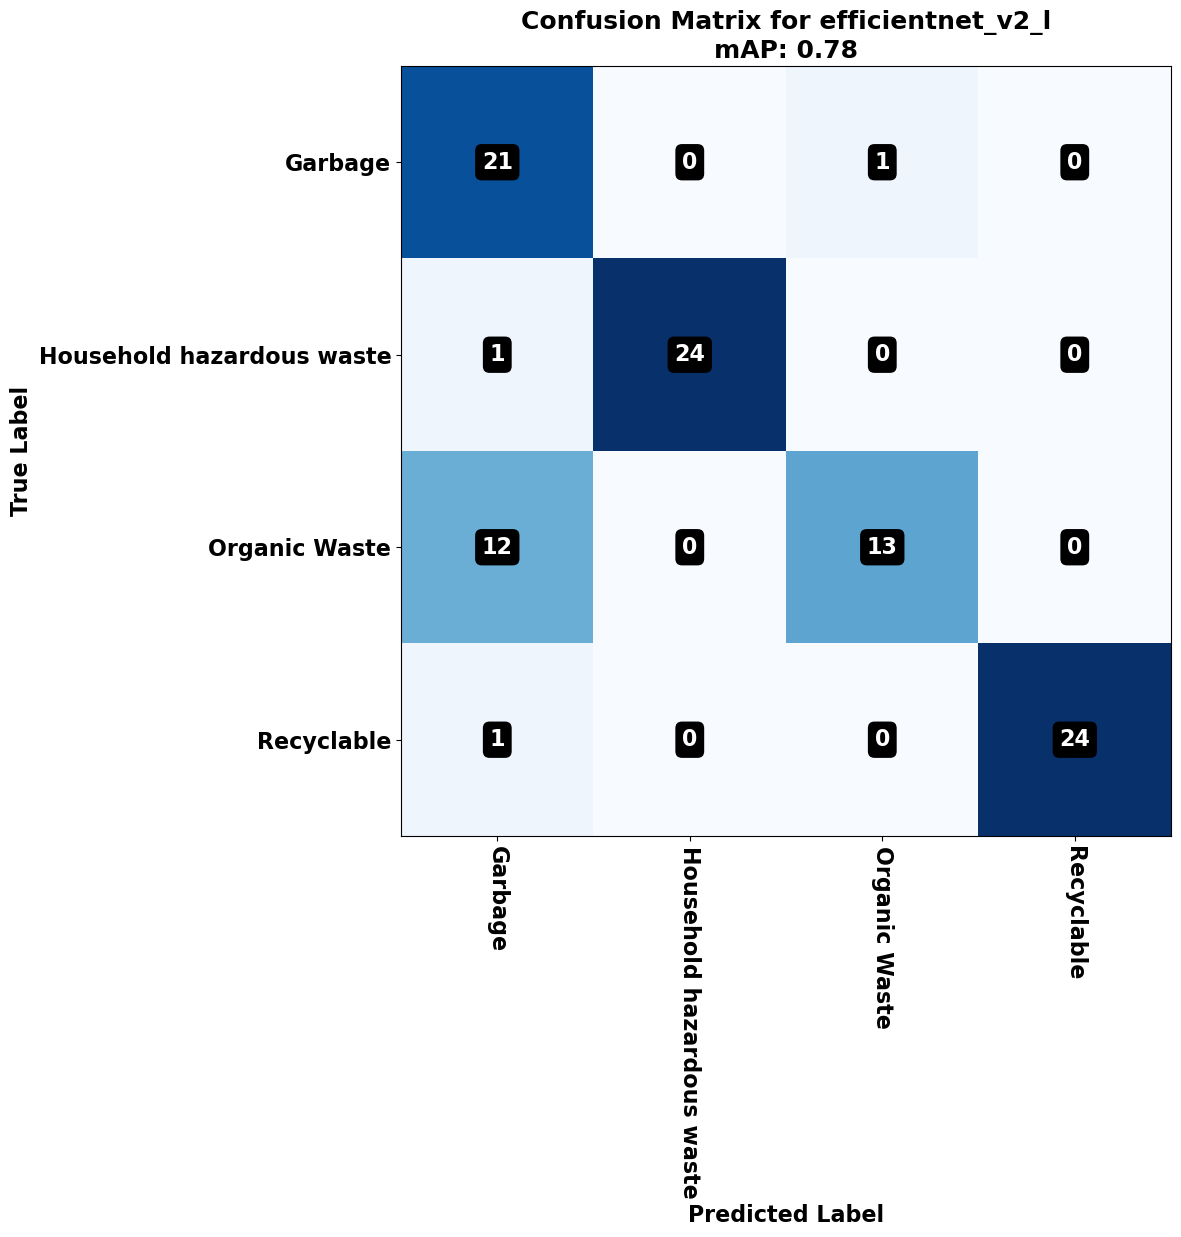

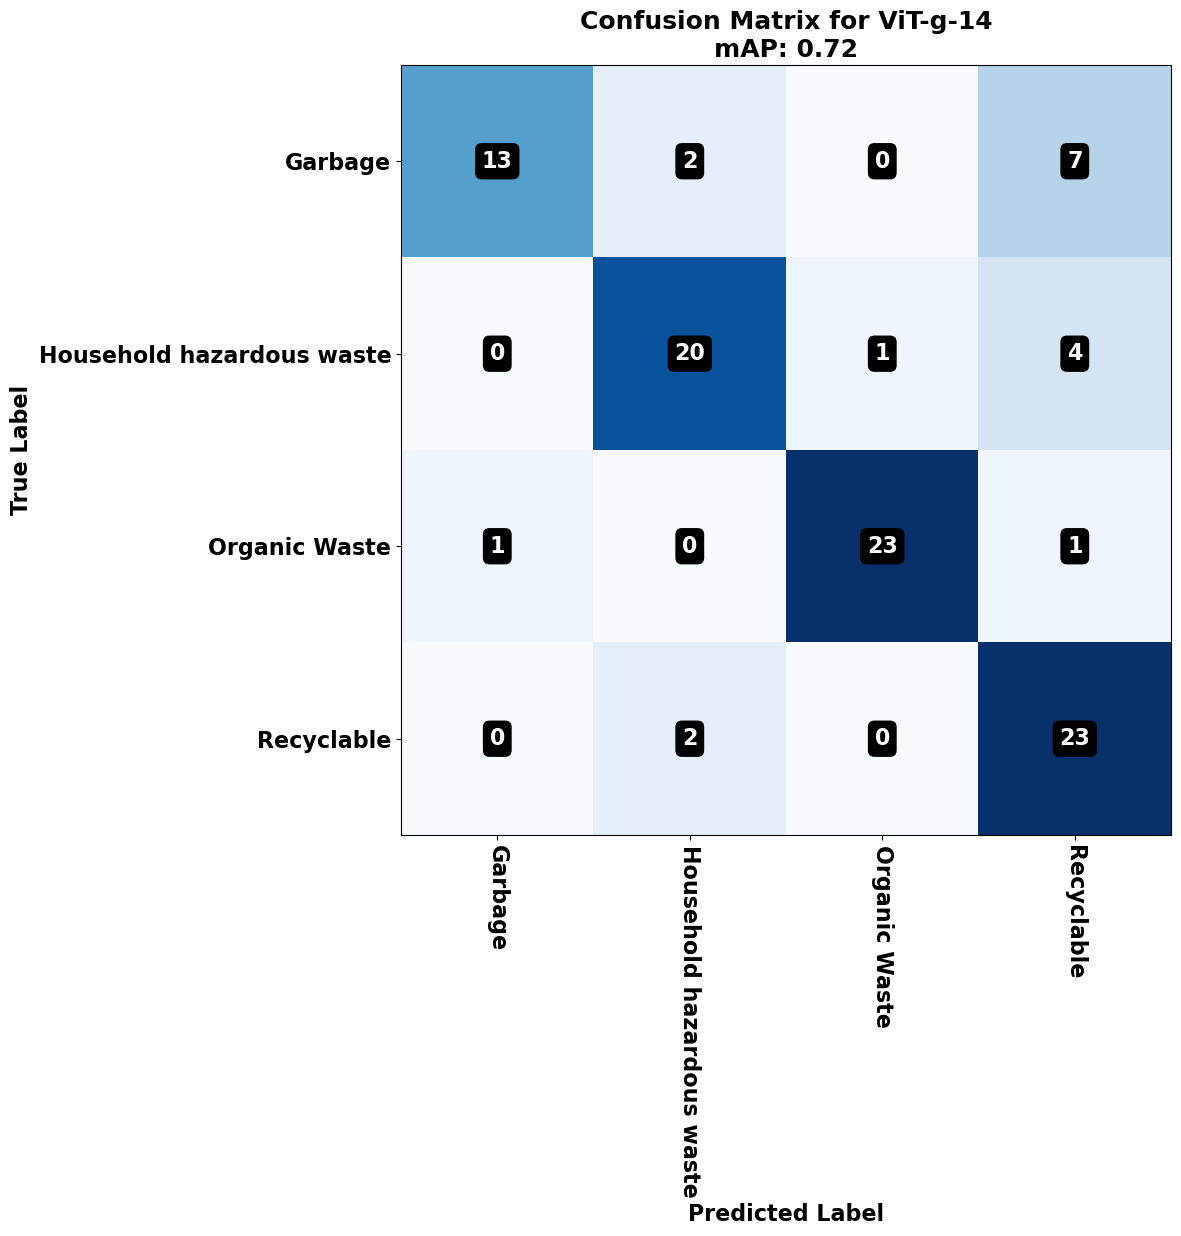

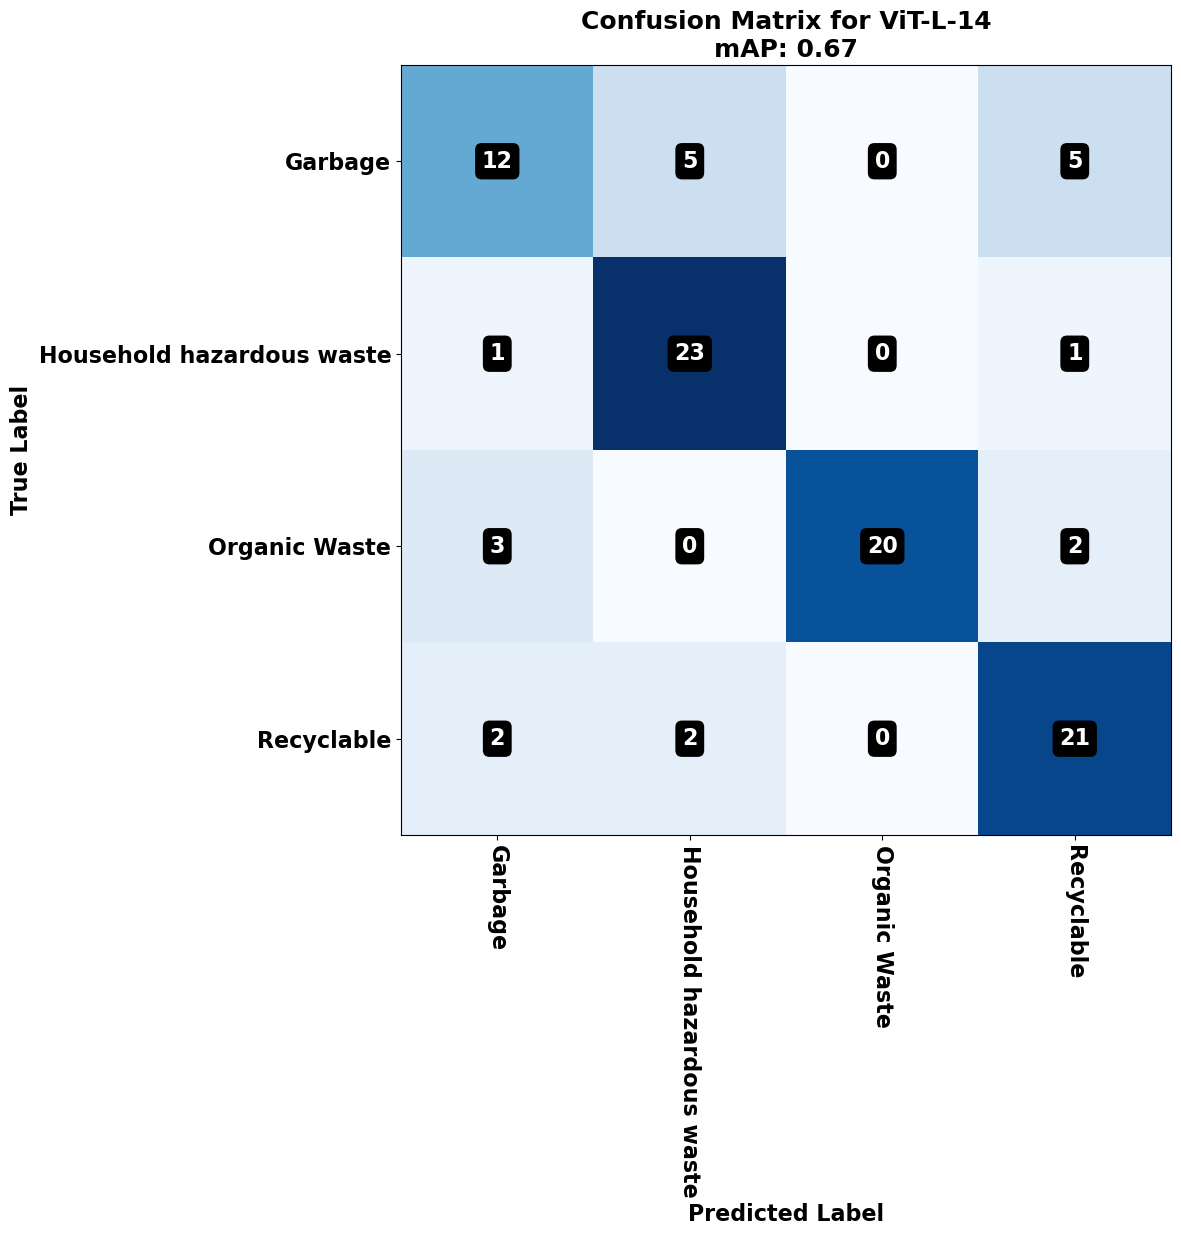

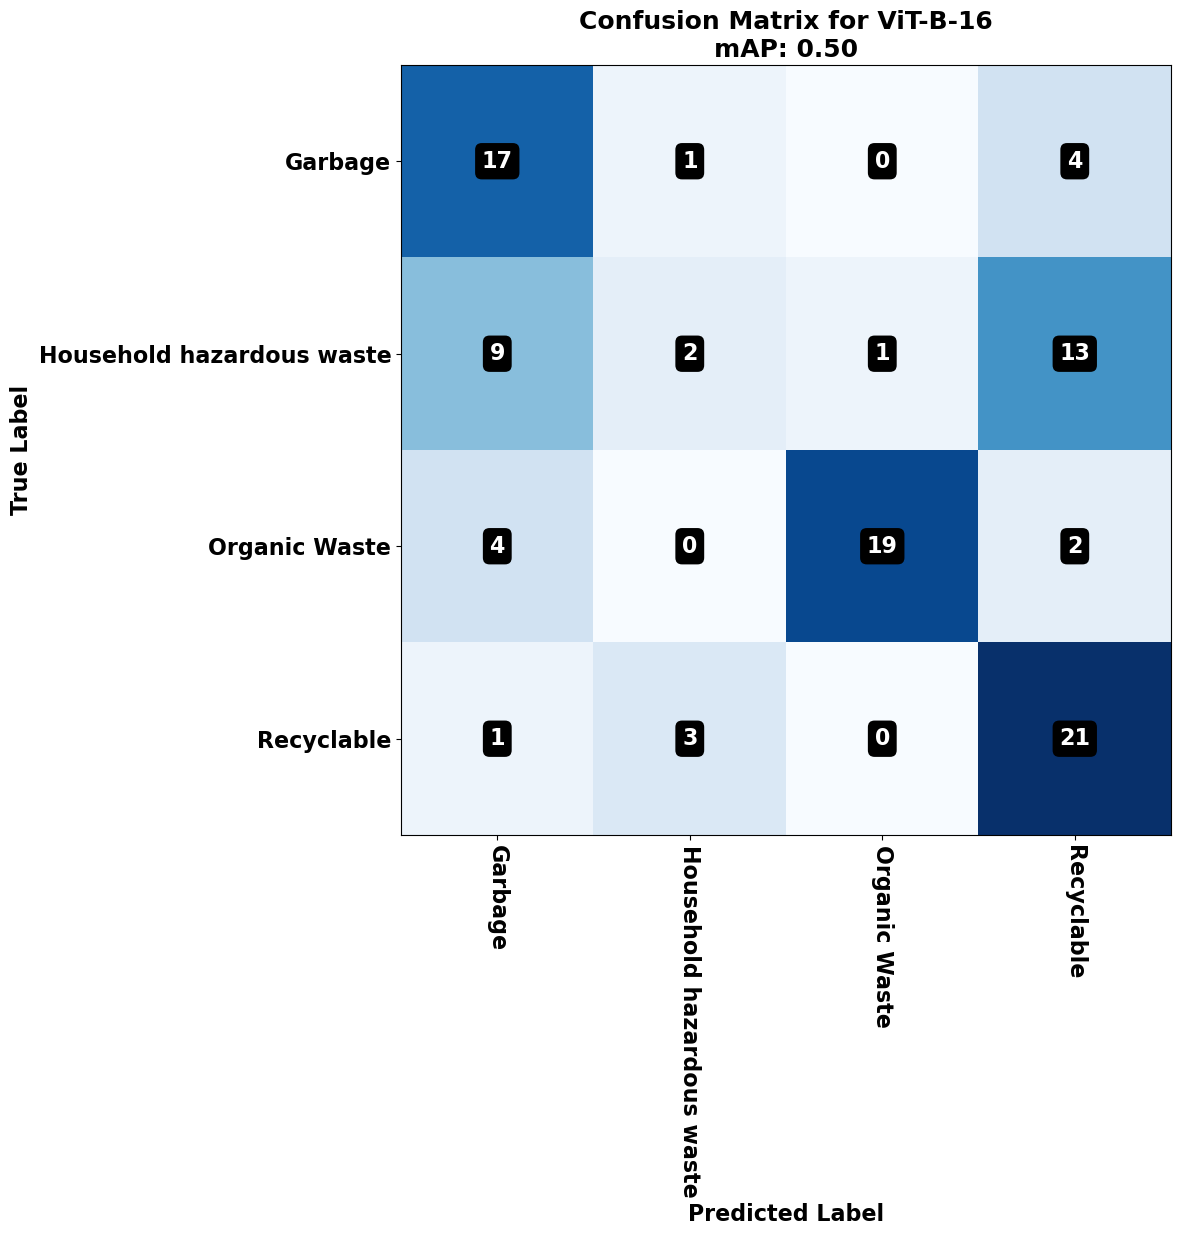

In [7]:
# loop over each model in predicted_classes_dict and labels_dict
for model in predicted_classes_dict.keys():
    # compute the confusion matrix
    confusion = confusion_matrix(labels_dict[model], predicted_classes_dict[model])
    
    # plot the confusion matrix with custom color map
    cmap = plt.cm.Blues
    cmap.set_bad(color='black')
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(confusion, cmap=cmap)

    # add labels and ticks to the plot
    classes = sorted(set(labels_dict[model]))
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, fontsize=16, fontweight='bold', rotation=-90)
    ax.set_yticklabels(classes, fontsize=16, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=16, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=16, fontweight='bold')

    # add the counts to the plot with better contrast
    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, confusion[i, j],
                           ha="center", va="center", color="w", fontsize=16, fontweight='bold',
                           bbox=dict(boxstyle='round', facecolor='black', edgecolor='none'))

    # add a title to the plot
    ax.set_title(f"Confusion Matrix for {model}\nmAP: {mAP_dict[model]:.2f}", fontsize=18, fontweight='bold')

    # show the plot
    plt.show()
